In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

In [4]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39337 instead
  f"Port {expected} is already in use.\n"


In [3]:
ds0,la,attrs,paramkey,keys = ppe_init()

In [4]:
#define some derived variables
#  derived = cf*v1/v2
specials={}
specials['WUE']={'v1':'GPP','v2':'EFLX_LH_TOT','cf':1,
                 'attrs':{'long_name':'Water use efficiency','units':'gC/kgH2O'}}
specials['CUE']={'v1':'NPP','v2':'GPP','cf':1,
                 'attrs':{'long_name':'Carbon use efficiency','units':'-'}}

specials['TOTVEGC-NPP']={'v1':'TOTVEGC','v2':'NPP','cf':1,
                 'attrs':{'long_name':'Veg carbon residence time','units':'years'}}
specials['TOTSOMC_1m-NPP']={'v1':'TOTSOMC_1m','v2':'NPP','cf':1,
                 'attrs':{'long_name':'1m soil carbon residence time','units':'years'}}


In [5]:
def get_da(ens_name,m,domain='global'):
    if m in specials:
        v1 = specials[m]['v1']
        v2 = specials[m]['v2']
        x1,iav = calc_mean(ens_name,v1,domain=domain)
        x2,iav = calc_mean(ens_name,v2,domain=domain)

        cf = specials[m]['cf']
        da = cf*x1/x2
        da.name  = m
        da.attrs = specials[m]['attrs']
    else:
        da,iav = calc_mean(ens_name,m,domain=domain)
        
    return da,iav

In [6]:
metrics = ['WUE','CUE','TLAI', 'GPP-TLAI',
           'SNOWDP','TOTVEGC-NPP','TOTSOMC_1m-NPP','FAREA_BURNED',
           'QRUNOFF','SOILWATER_10CM','TWS','FSR']

#collect annual means for all of the metrics
ens_name = 'CTL2010'
das=[]
for m in metrics:
    da = get_da(ens_name,m)
    das.append(da)

In [9]:
help(top_n)

Help on function top_n in module ppe_analysis.analysis:

top_n(da, nx, params, minmax, uniques=[])
    Sort for the largest perturbation effects
    
    returns lists of xmin, xmax, and the param_name for the top nx perturbations



In [38]:
ens_name = 'CTL2010'
plist=[]
for m in metrics:
    da,iav = get_da(ens_name,m)
    x1,x2,pvals = top_n(da,3,ds0.param,ds0.minmax)
    for p in pvals:
        if p not in plist:
            plist.append(p)
len(np.unique(plist))

24

In [39]:
ens_name = 'CTL2010'
for m in metrics:
    da,iav = get_da(ens_name,m)
    x1,x2,pvals = top_n(iav,3,ds0.param,ds0.minmax)
    for p in pvals:
        if p not in plist:
            plist.append(p)
len(np.unique(plist))

35

In [40]:
ens_name = 'CTL2010'
for m in metrics:
    da,iav = get_da(ens_name,m,domain='biome')
    for b in 1+np.arange(9):
        x1,x2,pvals = top_n(da.isel(biome=b),1,ds0.param,ds0.minmax)
        if abs(x1[0]-x2[0])>1e-10:
            if pvals[0] not in plist:
                plist.append(pvals[0])
len(np.unique(plist))

42

In [41]:
for m in metrics:
    da0,iav = get_da('CTL2010',m)
    for f in ['C285','C867','AF2095','AF1855','NDEP']:
        da1,iav = get_da(f,m)
        x1,x2,pvals = top_n(da1/da0,1,ds0.param,ds0.minmax)
        if abs(x1[0]-x2[0])>0.001:
            if pvals[0] not in plist:
                plist.append(pvals[0])
len(np.unique(plist))

48

In [42]:
plist=list(np.unique(plist))
ignores = ['e_ice','zetamaxstable','kn_nonmyc']
for i in ignores:
    plist.remove(i)
plist=sorted(plist,key=str.casefold)

In [43]:
f=open('selected.csv','w')
for p in plist:
    f.write(p+'\n')
f.close()

In [44]:
notplist=[]
for p in ds0.param.values:
    if p not in plist:
        if p not in notplist:
            notplist.append(p)
            
notplist=sorted(notplist,key=str.casefold)
f=open('not_selected.csv','w')
for p in notplist:
    f.write(p+'\n')
f.close()

In [41]:
m='SOILWATER_10CM'
ens_name = 'CTL2010'
das=[]
da0,iav =  get_da(ens_name,m)
das.append(da0)
das.append(iav)
for ens in ['C867','AF2095']:
    da,iav =  get_da(ens,m)
    da     = da/da0
    da.name=ens+'/CTL'
    da.attrs={'units':'-'}
    das.append(da)


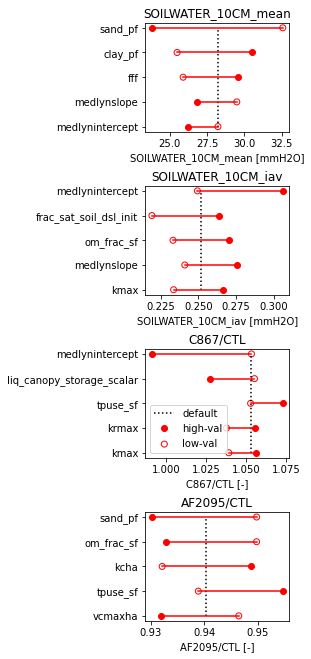

In [45]:
plt.figure(figsize=[5,11])
nx = len(das)
lls=[0,0,1,0]
for i,da in enumerate(das):
    plt.subplot(nx,1,i+1)
    rank_plot(da,ds0,5,ll=lls[i])

plt.subplots_adjust(left=0.5,hspace=0.5)
plt.savefig('../figs/lmwg22/sw10cm_lists.png')    


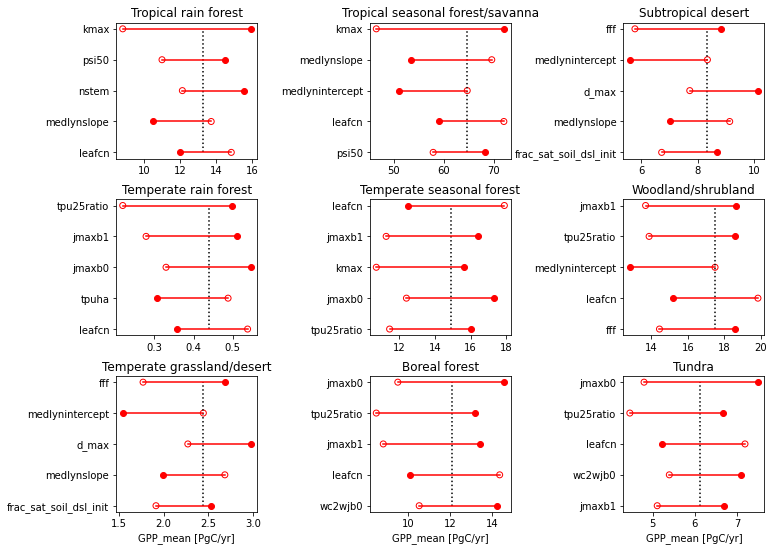

In [73]:
da,iav = get_da('CTL2010','GPP',domain='biome')
plt.figure(figsize=[15,9])
for i in 1+np.arange(9):
    plt.subplot(3,3,i)
    bname = str(ds0.biome_name[i].values)
    rank_plot(da.isel(biome=i),ds0,5,ll=False)
    plt.title(bname)
    if i<7:
        plt.xlabel('')
plt.subplots_adjust(left=0.3,wspace=0.8,hspace=0.3)
plt.savefig('../figs/lmwg22/gpp_biome_lists.png')

In [70]:
get_da('CTL2010','GPP',domain='biome')

(<xarray.DataArray 'SOILWATER_10CM_mean' (biome: 10, ens: 373)>
 array([[24.800427, 24.8012  , 24.79947 , ..., 24.79642 , 24.840256, 24.799865],
        [37.961091, 37.89539 , 38.041798, ..., 37.979011, 37.95148 , 37.955366],
        [28.747843, 28.690323, 28.834284, ..., 28.806469, 28.705587, 28.819436],
        ...,
        [17.34823 , 17.345183, 17.35641 , ..., 17.28615 , 17.376635, 17.458929],
        [43.671236, 43.617901, 43.769904, ..., 43.712944, 43.552919, 43.881719],
        [47.462319, 47.336709, 47.766866, ..., 47.210043, 47.659313, 48.289701]])
 Coordinates:
   * biome    (biome) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
   * ens      (ens) int64 0 1 2 3 4 5 6 7 8 ... 365 366 367 368 369 370 371 372
 Attributes:
     units:      mmH2O
     long_name:  soil liquid water + ice in top 10cm of soil (veg landunits only),
 <xarray.DataArray 'SOILWATER_10CM_iav' (biome: 10, ens: 373)>
 array([[0.099767, 0.099277, 0.100295, ..., 0.113037, 0.101554, 0.100958],
        [1.0270

In [9]:
def nplots(das,ds):

    plt.figure(figsize=[18,9])
    ll=True
    i=0
    for da in das:
        i+=1
        plt.subplot(3,4,i)
        rank_plot(da,ds,8,ll=ll)
        ll=False

        plt.xlabel('')
    plt.subplots_adjust(wspace=1.05)
    plt.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(left=0.2) 


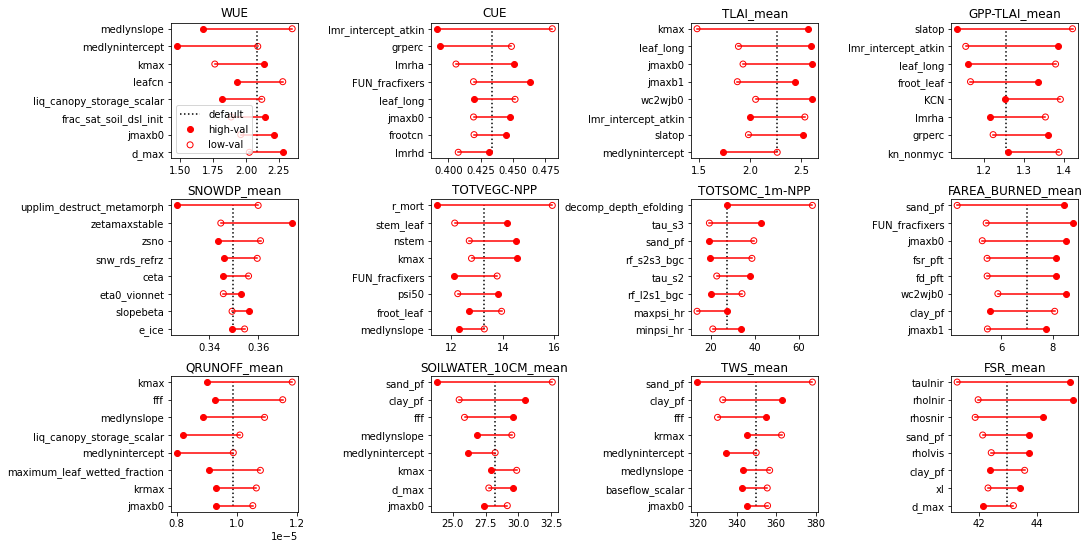

In [11]:
nplots(das,ds0)
plt.savefig('../figs/ctl2010/mainmetrics.pdf')

In [13]:
pdict={}
for da in das:
    [x1,x2,topn] = top_n(da,3,ds0.param,ds0.minmax)
    for p in topn:
        if p not in pdict:
            pdict[p]=[da.name]
        else:
            pdict[p].append(da.name)

In [14]:
pdict

{'kmax': ['WUE', 'TLAI_mean', 'QRUNOFF_mean'],
 'medlynintercept': ['WUE'],
 'medlynslope': ['WUE', 'QRUNOFF_mean'],
 'lmrha': ['CUE'],
 'grperc': ['CUE'],
 'lmr_intercept_atkin': ['CUE', 'GPP-TLAI_mean'],
 'jmaxb0': ['TLAI_mean', 'FAREA_BURNED_mean'],
 'leaf_long': ['TLAI_mean', 'GPP-TLAI_mean'],
 'slatop': ['GPP-TLAI_mean'],
 'zsno': ['SNOWDP_mean'],
 'zetamaxstable': ['SNOWDP_mean'],
 'upplim_destruct_metamorph': ['SNOWDP_mean'],
 'nstem': ['TOTVEGC-NPP'],
 'stem_leaf': ['TOTVEGC-NPP'],
 'r_mort': ['TOTVEGC-NPP'],
 'sand_pf': ['TOTSOMC_1m-NPP',
  'FAREA_BURNED_mean',
  'SOILWATER_10CM_mean',
  'TWS_mean'],
 'tau_s3': ['TOTSOMC_1m-NPP'],
 'decomp_depth_efolding': ['TOTSOMC_1m-NPP'],
 'FUN_fracfixers': ['FAREA_BURNED_mean'],
 'fff': ['QRUNOFF_mean', 'SOILWATER_10CM_mean', 'TWS_mean'],
 'clay_pf': ['SOILWATER_10CM_mean', 'TWS_mean'],
 'rhosnir': ['FSR_mean'],
 'rholnir': ['FSR_mean'],
 'taulnir': ['FSR_mean']}

In [15]:
len(pdict.keys())

24

In [38]:
0.85/12

0.07083333333333333

### manipulations

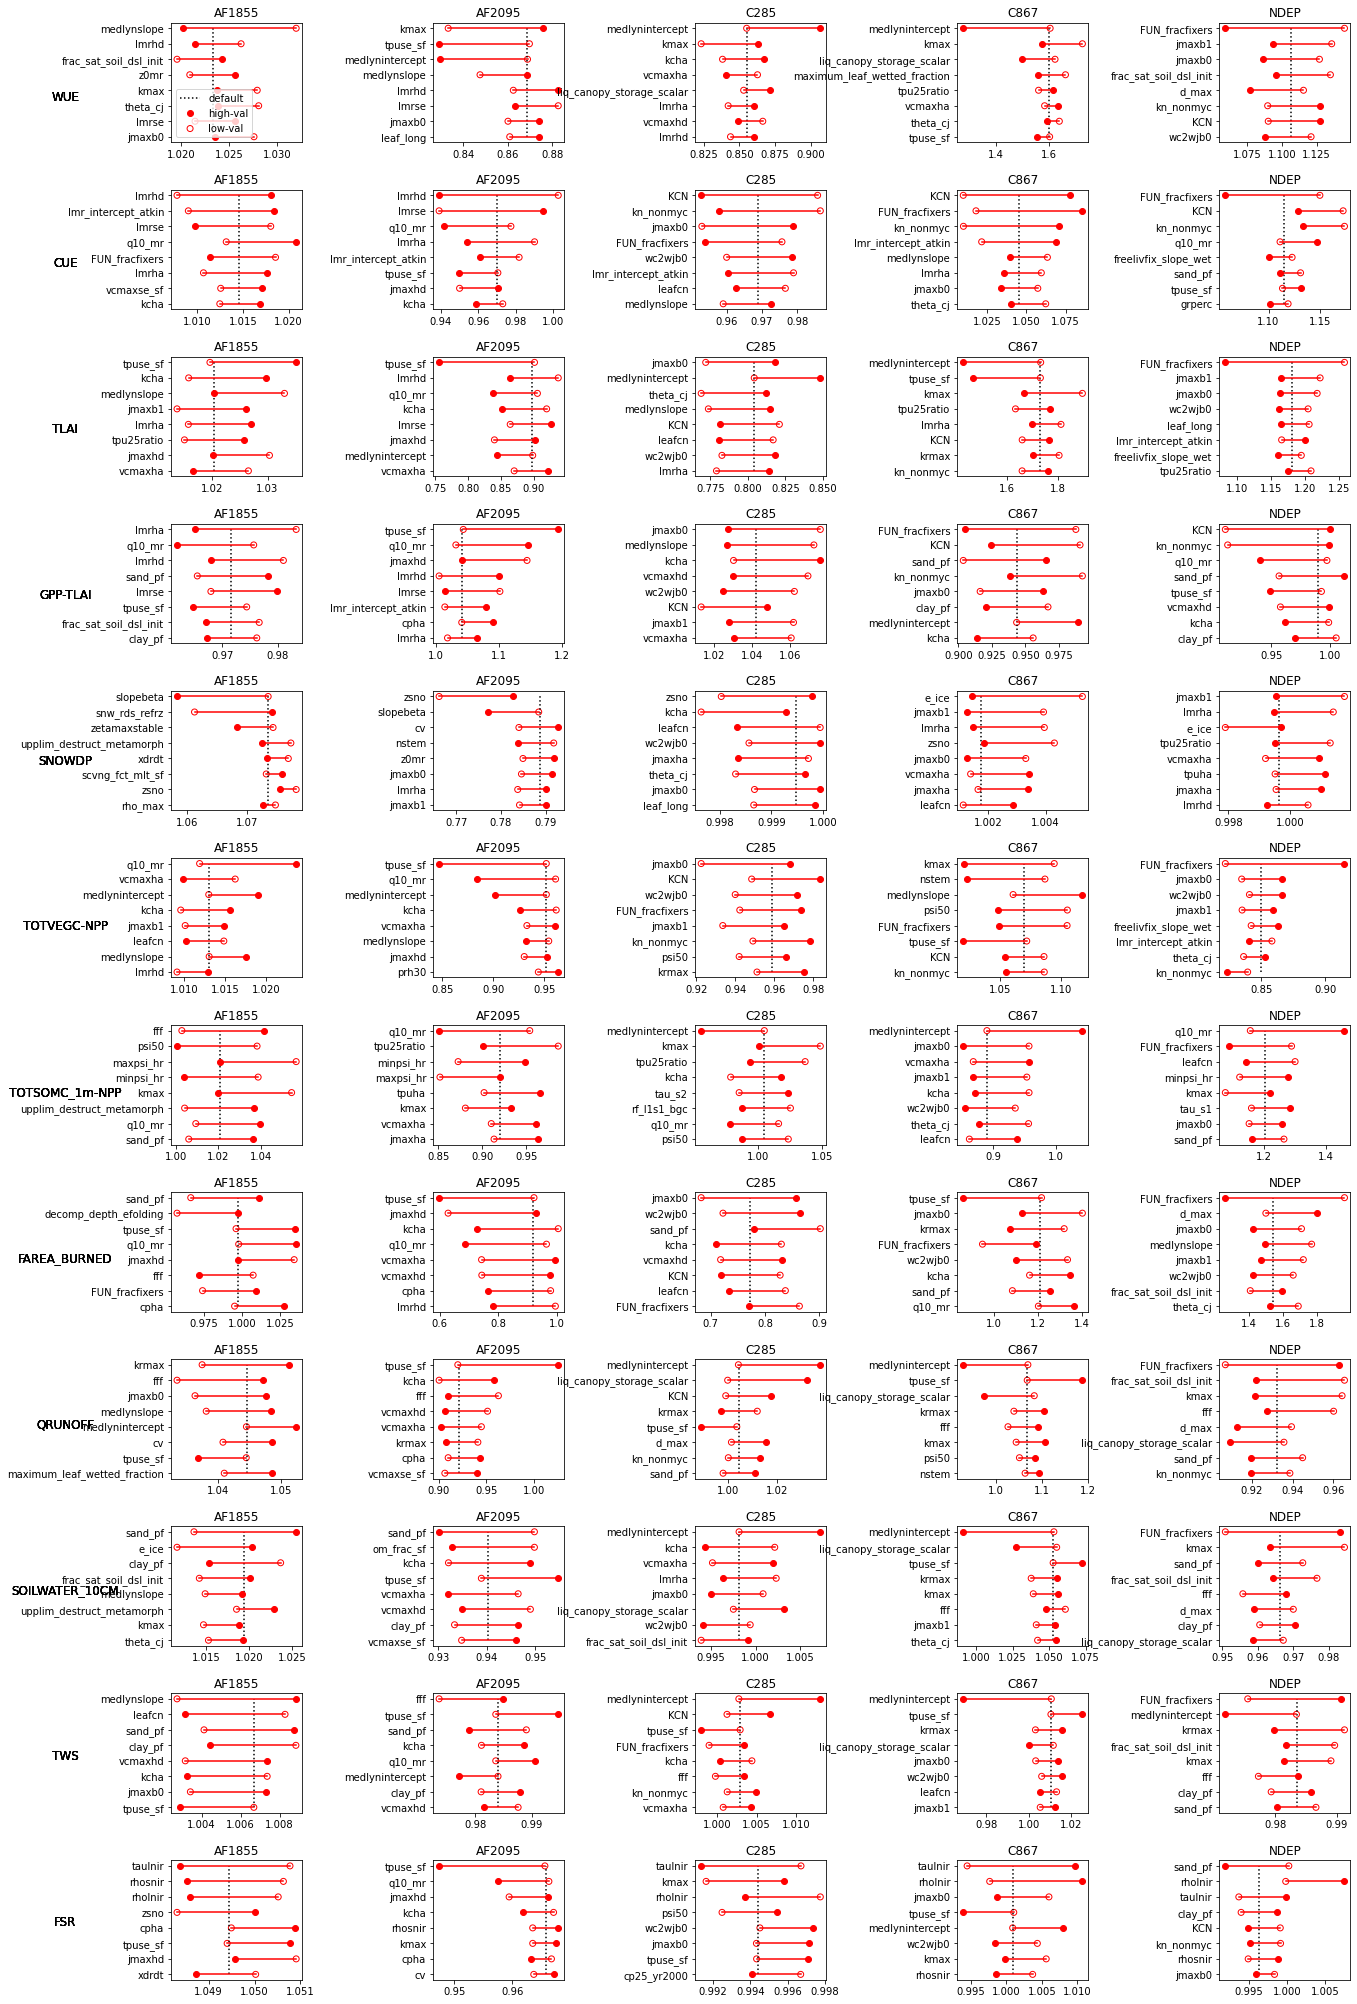

In [44]:
exps = ['AF1855','AF2095','C285','C867','NDEP']

nx = len(metrics)
h0 = 0.85
dh = 0.064

plt.figure(figsize=[21,3*nx])
i=0
r=-1
ll=True
for m in metrics:
    r+=1
    da1 = get_da('CTL2010',m)
    for exp in exps:
        da2 = get_da(exp,m)
        da = da2/da1
        da.name=exp
        da.attrs={'units':'(-)'}

        i+=1
        plt.subplot(nx,5,i)
        rank_plot(da,ds0,8,ll=ll)
        ll=False #legend
        plt.xlabel('')
        
        plt.figtext(0.05,h0-dh*r,m,fontsize=12,ha='center')
    
plt.subplots_adjust(wspace=1)
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(left=0.12) 

plt.savefig('../figs/manipulations/selection_metrics.pdf')

In [134]:
metrics = ['WUE','CUE','TLAI', 'GPP-TLAI',
           'SNOWDP','TOTVEGC-NPP','TOTSOMC_1m-NPP','FAREA_BURNED',
           'QRUNOFF','SOILWATER_10CM','TWS','FSR']
exps    = ['AF1855','AF2095','C285','C867','NDEP']
pdict={}

nctl = 3
nman = 1
nbio = 1
for m in metrics:
    exp = 'CTL2010'
    da1 = get_da(exp,m)
    x1,x2,pvals = top_n(da1,3,ds0.param,ds0.minmax)
    pdict = addp(pdict,pvals,exp)
    if nman>0:
        for exp in exps:
            da2 = get_da(exp,m)
            da  = da2/da1
            x1,x2,pvals = top_n(da,1,ds0.param,ds0.minmax)
            pdict = addp(pdict,pvals,exp)
    if nbio>0:
        exp = 'CTL2010'
        da = get_da(exp,m,domain='biome')
        for b in 1+np.arange(9):
            skipme=False
            if ((m=='SNOWDP')|(m=='FAREA_BURNED'))&(da.sel(ens=0,biome=b).values<0.001):
                skipme=True
            if not skipme:
                x1,x2,pvals = top_n(da.sel(biome=b),1,ds0.param,ds0.minmax)
            pdict = addp(pdict,pvals,exp)
            
    

In [172]:
plist=list(pdict.keys())
ignores = ['e_ice','zetamaxstable','kn_nonmyc']
for i in ignores:
    plist.remove(i)
plist=sorted(plist,key=str.casefold)

In [179]:
notplist=[]
for p in ds0.param.values:
    if p not in plist:
        if p not in notplist:
            notplist.append(p)
            
notplist=sorted(notplist,key=str.casefold)
f=open('not_selected.csv','w')
for p in notplist:
    f.write(p+'\n')
f.close()
        

In [143]:
ignores = ['zetamaxstable','kn_nonmyc']

[plist.remove(i) for i in ignores]
plist

ValueError: list.remove(x): x not in list

True

In [119]:
whit.biome_name

<xarray.DataArray 'biome_name' (biome_id: 10)>
array(['Ice sheet', 'Tropical rain forest', 'Tropical seasonal forest/savanna',
       'Subtropical desert', 'Temperate rain forest',
       'Temperate seasonal forest', 'Woodland/shrubland',
       'Temperate grassland/desert', 'Boreal forest', 'Tundra'], dtype=object)
Coordinates:
  * biome_id  (biome_id) int64 0 1 2 3 4 5 6 7 8 9

### biomes

In [110]:
ll=True
i=0

h0 = 0.923
dh = 0.087
first=True
j=-1
k=0
for m in metrics:
    j+=1;k+=1
    if j==0:
        plt.figure(figsize=[18,27])
    da = get_da('CTL2010',m,domain='biome')
    for b in 1+np.arange(9):

        i=(b-1)*4+j+1
        plt.subplot(9,4,i)
        rank_plot(da.sel(biome=b),ds0,8,ll=ll)
        bname = whit.biome_name.sel(biome_id=b).values
        plt.title(m)
        plt.xlabel('')
        ll=False
        if first:
            plt.figtext(0.1,h0-dh*b,bname,fontsize=12,ha='center')
    first=False
    
    if j==3:
        j = -1; first=True
        n = str(int(k/4))
        plt.subplots_adjust(wspace=1)
        plt.subplots_adjust(hspace=0.4)
        plt.subplots_adjust(left=0.25)
        plt.savefig('../figs/biomes/metrics_'+n+'.pdf')
plt.close("all")

### iav

In [69]:
## iav is trickier, because you need to compute derived annually and then take iav
## whereas currently we are computing derived as ann mean / ann mean